In [65]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.


In [66]:
!pip install scikit-plot

In [67]:
import os
print(os.getcwd())

/content


y.shape (29601, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(14801,) (14801, 2)


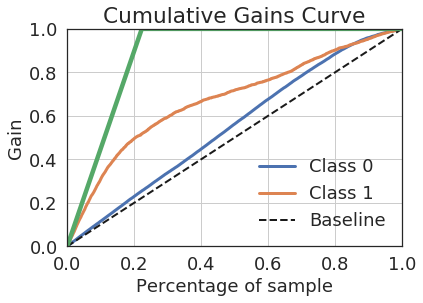

XTrain.shape, Y_train_onehot.shape (14800, 23) (14800, 2)
Confusion matrix

###################  Training  ###############

Training Confusion matrix: 
 [[1.   0.  ]
 [0.99 0.01]]

Training Accuracy score: 
 0.7769594594594594

Train AUC: 
 0.5040243631666061

###################  Testing  ###############

Test Confusion matrix: 
 [[1.   0.  ]
 [0.99 0.01]]

Test Accuracy score: 
 0.7781230997905547

TestAUC: 
 0.5038594865442236


array([array([[1.  , 0.  ],
       [0.99, 0.01]]), 0.7769594594594594,
       0.5040243631666061, array([[1.  , 0.  ],
       [0.99, 0.01]]),
       0.7781230997905547, 0.5038594865442236], dtype=object)

In [68]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import scale
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scp
import seaborn
import scikitplot as skplt

"""Load credit card data"""
# https://compphysics.github.io/MachineLearning/doc/pub/LogReg/html/LogReg.html
# https://bradzzz.gitbooks.io/ga-seattle-dsi/content/dsi/dsi_05_classification_databases/2.1-lesson/assets/datasets/DefaultCreditCardClients_yeh_2009.pdf
# https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
# https://compphysics.github.io/MachineLearning/doc/pub/Splines/html/Splines-bs.html
# https://compphysics.github.io/MachineLearning/doc/pub/NeuralNet/html/NeuralNet-bs.html
# http://neuralnetworksanddeeplearning.com/

# Reading file into data frame

#cwd = os.getcwd() # For getting data from local machine
#filename = cwd + '/default of credit card clients.xls' # For getting data from local machine
#df = pd.read_excel(filename, header=1, skiprows=0, index_col=0, na_values=nanDict) # For getting data from local machine

#url = "https://github.com/laurent0001/FYS-STK4155---project-2/blob/master/default%20of%20credit%20card%20clients.xls?raw=true" #Unfiltered data
url = "https://github.com/laurent0001/FYS-STK4155---project-2/blob/master/default%20of%20credit%20card%20clients%20(filtered).xls?raw=true" #Filtered data
nanDict = {}
df = pd.read_excel(url, header=1, skiprows=0, index_col=0, na_values=nanDict)


df.rename(index=str, columns={"default payment next month": "defaultPaymentNextMonth"}, inplace=True)

# Features and targets 
X = df.loc[:, df.columns != 'defaultPaymentNextMonth'].values
y = df.loc[:, df.columns == 'defaultPaymentNextMonth'].values
print("y.shape", y.shape)

# Categorical variables to one-hot's
#onehotencoder = OneHotEncoder(categories='auto')

onehotencoder = OneHotEncoder()
#onehotencoder = OneHotEncoder(dtype='binary')

# Train-test split
trainingShare = 0.5 
seed  = 1
XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size=trainingShare, \
                                              test_size = 1-trainingShare,
                                             random_state=seed)
# Input Scaling
sc = StandardScaler()
XTrain = sc.fit_transform(XTrain)
XTest = sc.transform(XTest)

# One-hot's of the target vector
#Y_train_onehot, Y_test_onehot = onehotencoder.fit_transform(yTrain), onehotencoder.fit_transform(yTest)
Y_train_onehot = onehotencoder.fit_transform(yTrain) # Use fit_transform once on a subset of the data, then transform on the associated subsets so that the same values among the subsets are attributed the same classes.
Y_test_onehot = onehotencoder.transform(yTest)

# Remove instances with zeros only for past bill statements or paid amounts
'''
df = df.drop(df[(df.BILL_AMT1 == 0) &
                (df.BILL_AMT2 == 0) &
                (df.BILL_AMT3 == 0) &
                (df.BILL_AMT4 == 0) &
                (df.BILL_AMT5 == 0) &
                (df.BILL_AMT6 == 0) &
                (df.PAY_AMT1 == 0) &
                (df.PAY_AMT2 == 0) &
                (df.PAY_AMT3 == 0) &
                (df.PAY_AMT4 == 0) &
                (df.PAY_AMT5 == 0) &
                (df.PAY_AMT6 == 0)].index)
'''
df = df.drop(df[(df.BILL_AMT1 == 0) &
                (df.BILL_AMT2 == 0) &
                (df.BILL_AMT3 == 0) &
                (df.BILL_AMT4 == 0) &
                (df.BILL_AMT5 == 0) &
                (df.BILL_AMT6 == 0)].index)

df = df.drop(df[(df.PAY_AMT1 == 0) &
                (df.PAY_AMT2 == 0) &
                (df.PAY_AMT3 == 0) &
                (df.PAY_AMT4 == 0) &
                (df.PAY_AMT5 == 0) &
                (df.PAY_AMT6 == 0)].index)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lambdas=np.logspace(-5,7,13)
parameters = [{'C': 1./lambdas, "solver":["lbfgs"]}]#*len(parameters)}]
scoring = ['accuracy', 'roc_auc']
logReg = LogisticRegression()
gridSearch = GridSearchCV(logReg, parameters, cv=5, scoring=scoring, refit='roc_auc') 

# "refit" gives the metric used deciding best model. 
# See more http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
gridSearch.fit(XTrain, yTrain.ravel())

def gridSearchSummary(method, scoring):
    """Prints best parameters from Grid search
    and AUC with standard deviation for all 
    parameter combos """
    
    method = eval(method)
    if scoring == 'accuracy':
        mean = 'mean_test_score'
        sd = 'std_test_score'
    elif scoring == 'auc':
        mean = 'mean_test_roc_auc'
        sd = 'std_test_roc_auc'
    print("Best: %f using %s" % (method.best_score_, method.best_params_))
    means = method.cv_results_[mean]
    stds = method.cv_results_[sd]
    params = method.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

def createConfusionMatrix(method, printOut=True):
    """
    Computes and prints confusion matrices, accuracy scores,
    and AUC for test and training sets 
    """
    confusionArray = np.zeros(6, dtype=object)
    method = eval(method)
    
    # Train
    yPredTrain = method.predict(XTrain)
    yPredTrain = (yPredTrain > 0.5)
    cm = confusion_matrix(
        yTrain, yPredTrain) 
    cm = np.around(cm/cm.sum(axis=1)[:,None], 2)
    confusionArray[0] = cm
    
    accScore = accuracy_score(yTrain, yPredTrain)
    confusionArray[1] = accScore
    
    AUC = roc_auc_score(yTrain, yPredTrain)
    confusionArray[2] = AUC
    
    if printOut:
        print('\n###################  Training  ###############')
        print('\nTraining Confusion matrix: \n', cm)
        print('\nTraining Accuracy score: \n', accScore)
        print('\nTrain AUC: \n', AUC)
    
    # Test
    yPred = method.predict(XTest)
    yPred = (yPred > 0.5)
    cm = confusion_matrix(
        yTest, yPred) 
    cm = np.around(cm/cm.sum(axis=1)[:,None], 2)
    confusionArray[3] = cm
    
    accScore = accuracy_score(yTest, yPred)
    confusionArray[4] = accScore
    
    AUC = roc_auc_score(yTest, yPred)
    confusionArray[5] = AUC
    
    if printOut:
        print('\n###################  Testing  ###############')
        print('\nTest Confusion matrix: \n', cm)
        print('\nTest Accuracy score: \n', accScore)
        print('\nTestAUC: \n', AUC)    
    
    return confusionArray

seaborn.set(style="white", context="notebook", font_scale=1.5, 
            rc={"axes.grid": True, "legend.frameon": False,
"lines.markeredgewidth": 1.4, "lines.markersize": 10})
seaborn.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4.5})

yPred = gridSearch.predict_proba(XTest) 
print(yTest.ravel().shape, yPred.shape)

# Plot cummulative gain curve

#skplt.metrics.plot_cumulative_gain(yTest.ravel(), yPred_onehot)
skplt.metrics.plot_cumulative_gain(yTest.ravel(), yPred)

defaults = sum(yTest == 1)
total = len(yTest)
defaultRate = defaults/total
def bestCurve(defaults, total, defaultRate):
    x = np.linspace(0, 1, total)
    
    y1 = np.linspace(0, 1, defaults)
    y2 = np.ones(total-defaults)
    y3 = np.concatenate([y1,y2])
    return x, y3

x, best = bestCurve(defaults=defaults, total=total, defaultRate=defaultRate)    
plt.plot(x, best)    
plt.show()
print("XTrain.shape, Y_train_onehot.shape", XTrain.shape, Y_train_onehot.shape)

# Plot confusion matrix
print("Confusion matrix")
createConfusionMatrix("Ridge(alpha = optimal_lambda_ridge, fit_intercept=False).fit(XTrain, yTrain)", printOut=True)


In [69]:
# Grid search
from sklearn.model_selection import GridSearchCV
gridSearchSummary("gridSearch.fit(XTrain, yTrain.ravel())", 'auc') # Scoring is either of 'accuracy' and 'auc'

Best: 0.718668 using {'C': 0.1, 'solver': 'lbfgs'}
0.718635 (0.010019) with: {'C': 99999.99999999999, 'solver': 'lbfgs'}
0.718635 (0.010018) with: {'C': 10000.0, 'solver': 'lbfgs'}
0.718636 (0.010019) with: {'C': 1000.0, 'solver': 'lbfgs'}
0.718637 (0.010020) with: {'C': 100.0, 'solver': 'lbfgs'}
0.718637 (0.010018) with: {'C': 10.0, 'solver': 'lbfgs'}
0.718644 (0.010022) with: {'C': 1.0, 'solver': 'lbfgs'}
0.718668 (0.010053) with: {'C': 0.1, 'solver': 'lbfgs'}
0.718489 (0.009895) with: {'C': 0.01, 'solver': 'lbfgs'}
0.712206 (0.008692) with: {'C': 0.001, 'solver': 'lbfgs'}
0.699539 (0.008040) with: {'C': 0.0001, 'solver': 'lbfgs'}
0.695089 (0.007554) with: {'C': 1e-05, 'solver': 'lbfgs'}
0.694648 (0.007500) with: {'C': 1e-06, 'solver': 'lbfgs'}
0.694598 (0.007477) with: {'C': 1e-07, 'solver': 'lbfgs'}


rf confusion matrix


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


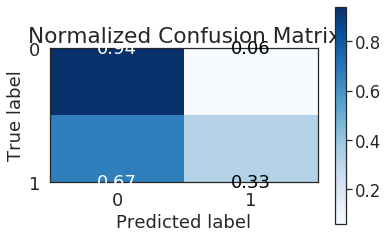

With onehot y


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


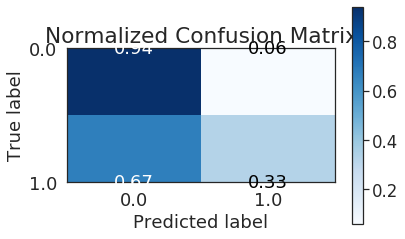

In [70]:
# Confusion matrix
from sklearn.ensemble import RandomForestClassifier
print("rf confusion matrix")
rf = RandomForestClassifier()
#print("XTrain, yTrain", XTrain.shape, yTrain.shape)
rf = rf.fit(XTrain, yTrain.ravel())
yPred = rf.predict(XTest).ravel()
#print("yTest, yPred", yTest.ravel().shape, yPred.shape)
skplt.metrics.plot_confusion_matrix(yTest.ravel(), yPred, normalize=True)
plt.show()

# With onehot y
print("With onehot y")
rf = RandomForestClassifier()
rf = rf.fit(XTrain, Y_train_onehot.todense())
yPred = rf.predict(XTest)
Y_test_onehot=onehotencoder.inverse_transform(Y_test_onehot) # Use inverse_transform to reverse the OneHotEncoder encoding back to input data type
yPred=onehotencoder.inverse_transform(yPred) # Use inverse_transform to reverse the OneHotEncoder encoding back to input data type
skplt.metrics.plot_confusion_matrix(Y_test_onehot, yPred, normalize=True)
plt.show()

# Check seaborn documentation for data visualization


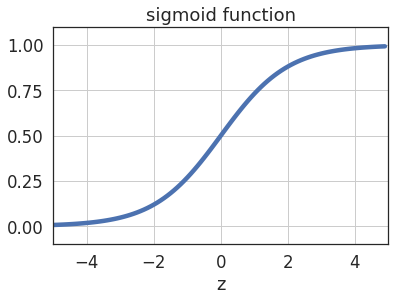

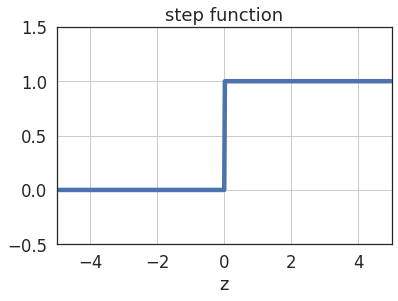

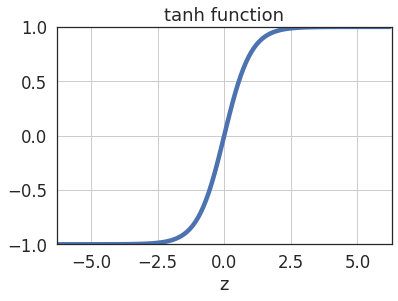

In [71]:
# Activation functions
import math as math

"""Sigmoid Function"""
z = np.arange(-5, 5, .1)
sigma_fn = np.vectorize(lambda z: 1/(1+np.exp(-z)))
sigma = sigma_fn(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, sigma)
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-5,5])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('sigmoid function')
plt.show()

def SigmoidFunction(x):
  sigma_fn = np.vectorize(lambda x: 1/(1+np.exp(-x)))
  return 1/(1+np.exp(-x))

"""Step Function"""
z = np.arange(-5, 5, .02)
step_fn = np.vectorize(lambda z: 1.0 if z >= 0.0 else 0.0)
step = step_fn(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, step)
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([-5,5])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('step function')
plt.show()

#def StepFunction():

"""tanh Function"""
z = np.arange(-2*math.pi, 2*math.pi, 0.1)
t = np.tanh(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, t)
ax.set_ylim([-1.0, 1.0])
ax.set_xlim([-2*math.pi,2*math.pi])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('tanh function')
plt.show()

#def TanhFunction():

In [72]:
# Making the design matrix for credit card data
#Transform data with scaling and onehotencoder
continuous_indices = [0,4,11,12,13,14,15,16,17,18,19,20,21,22] #Do not include column of ones for LG

onehotencoder = OneHotEncoder(categories='auto')
sc = StandardScaler()

X_ccd_cont = ColumnTransformer([("", sc, continuous_indices),], remainder="passthrough").fit_transform(X)
X_ccd = ColumnTransformer([("", onehotencoder, np.arange(14,23)),], remainder="passthrough").fit_transform(X_ccd_cont)
y_ccd = onehotencoder.fit_transform(y).toarray()

# Splitting the data
def SplitData(X, y, trainingShare=0.5):
  seed  = 1
  XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size=trainingShare, \
                                              test_size = 1-trainingShare,
                                             random_state=seed)
  return XTrain, XTest, yTrain, yTest

def accuracy(yTest, yPred):
  #print(yTest)
  #print(yPred)
  yP = yPred.copy().flatten()
  yT = yTest.copy().flatten()
  return  (yT == yP).sum()/len(yT)

def LogRegPredict(XTest, beta):
  yPred = SigmoidFunction(XTest @ beta)
  for i in range(0, yPred.shape[0], 1):
    if yPred[i] <= 0.5:
      yPred[i] = 0
    else:
      yPred[i] = 1
  return yPred

import random

def shuffle(XTrain, yTrain):
  random.seed(1)
  n_rows = list(range(0, XTrain.shape[0], 1))
  random.shuffle(n_rows)
  XTrain_post_shuffle = XTrain[n_rows,:]
  yTrain_post_shuffle = yTrain[n_rows]
  return XTrain_post_shuffle, yTrain_post_shuffle

def step_length(t,t0,t1):
    return t0/(t+t1)

def LogisticRegressionOwnMB_SGD(X, y, trainingShare=0.5, batch_size = 20, n_iter = 200): #Stochastic gradient descent (with mini-batches)
  split_data = SplitData(X, y, trainingShare)
  XTrain = split_data[0]
  XTest = split_data[1]
  yTrain = split_data[2]
  yTest = split_data[3]
  np.random.seed(1)
  t0, t1 = 5, 50
  beta = np.random.randn(XTrain.shape[1], yTrain.shape[1])
  costs = []
  accuracy_list = []
  accuracy_list.append(accuracy(yTest, LogRegPredict(XTest, beta)))
  for i in range(n_iter):
    shuffled_data = shuffle(XTrain, yTrain) # Rows for XTrain, yTrain are shuffled for each epoch.
    XTrain_shuffled = shuffled_data[0]
    yTrain_shuffled = shuffled_data[1]
    for batch in range(int(XTrain.shape[0]/batch_size)):
      XTrain_batch = XTrain_shuffled[batch_size * batch: batch_size * (batch + 1), :]
      yTrain_batch = yTrain_shuffled[batch_size * batch: batch_size * (batch + 1)]
      h_x_batch = XTrain_batch @ beta
      cost = -np.sum((np.transpose(yTrain_batch)) @ SigmoidFunction(h_x_batch) - np.log(SigmoidFunction(h_x_batch))) # Cross-entropy cost function
      gradients =  -(np.transpose(XTrain_batch)@(yTrain_batch - SigmoidFunction(h_x_batch)))
      t = i*int(XTrain.shape[0]/batch_size) + batch
      eta = step_length(t, t0, t1)
      beta -= eta*gradients
    costs.append(cost)
    yPred = LogRegPredict(XTest, beta)
    accuracy_list.append(accuracy(yTest, yPred))
  return beta, costs, accuracy_list

def LogisticRegressionOwnMB(X, y, trainingShare=0.5, eta = 0.00001, batch_size = 20, n_iter = 200): #With mini-batches
  split_data = SplitData(X, y, trainingShare)
  XTrain = split_data[0]
  XTest = split_data[1]
  yTrain = split_data[2]
  yTest = split_data[3]
  np.random.seed(1)
  beta = np.random.randn(XTrain.shape[1], yTrain.shape[1])
  costs = []
  accuracy_list = []
  accuracy_list.append(accuracy(yTest, LogRegPredict(XTest, beta)))
  for i in range(n_iter):
    shuffled_data = shuffle(XTrain, yTrain) # Rows for XTrain, yTrain are shuffled for each epoch.
    XTrain_shuffled = shuffled_data[0]
    yTrain_shuffled = shuffled_data[1]
    for batch in range(int(XTrain.shape[0]/batch_size)):
      XTrain_batch = XTrain_shuffled[batch_size * batch: batch_size * (batch + 1), :]
      yTrain_batch = yTrain_shuffled[batch_size * batch: batch_size * (batch + 1)]
      h_x_batch = XTrain_batch @ beta
      cost = -np.sum((np.transpose(yTrain_batch)) @ SigmoidFunction(h_x_batch) - np.log(SigmoidFunction(h_x_batch))) # Cross-entropy cost function
      gradients =  -(np.transpose(XTrain_batch)@(yTrain_batch - SigmoidFunction(h_x_batch)))
      beta -= eta*gradients
    costs.append(cost)
    yPred = LogRegPredict(XTest, beta)
    accuracy_list.append(accuracy(yTest, yPred))
  return beta, costs, accuracy_list

def LogisticRegressionOwn(X, y, trainingShare=0.5, eta = 0.00001,n_iter = 200):  #Without mini-batches
  split_data = SplitData(X, y, trainingShare)
  XTrain = split_data[0]
  XTest = split_data[1]
  yTrain = split_data[2]
  yTest = split_data[3]
  np.random.seed(1)
  beta = np.random.randn(XTrain.shape[1], yTrain.shape[1])
  costs = []
  accuracy_list = []
  accuracy_list.append(accuracy(yTest, LogRegPredict(XTest, beta)))
  for i in range(n_iter):
    shuffled_data = shuffle(XTrain, yTrain) # Rows for XTrain, yTrain are shuffled for each epoch.
    XTrain_shuffled = shuffled_data[0]
    yTrain_shuffled = shuffled_data[1]
    h_x = XTrain_shuffled @ beta
    cost = -np.sum((np.transpose(yTrain_shuffled)) @ SigmoidFunction(h_x) - np.log(SigmoidFunction(h_x))) # Cross-entropy cost function
    gradients =  -(np.transpose(XTrain_shuffled)@(yTrain_shuffled - SigmoidFunction(h_x)))
    beta -= eta*gradients
    costs.append(cost)
    yPred = LogRegPredict(XTest, beta)
    accuracy_list.append(accuracy(yTest, yPred))
  return beta, costs, accuracy_list

"""
eta = 0.00001
n_iter = 20
beta = np.random.randn(91,1)
batch_size = 50
costs = []
accuracy_list = []
for i in range(n_iter):
    shuffled_data = shuffle(XTrain, yTrain) # Rows for XTrain, yTrain are shuffled for each epoch.
    XTrain_shuffled = shuffled_data[0]
    yTrain_shuffled = shuffled_data[1]
    for batch in range(int(XTrain.shape[0]/batch_size)):
      XTrain_batch = XTrain_shuffled[batch_size * batch: batch_size * (batch + 1), :]
      yTrain_batch = yTrain_shuffled[batch_size * batch: batch_size * (batch + 1)]
      h_x_batch = XTrain_batch @ beta
      cost = -np.sum((np.transpose(yTrain_batch)) @ SigmoidFunction(h_x_batch) - np.log(SigmoidFunction(h_x_batch))) # Cross-entropy cost function
      gradients =  -(np.transpose(XTrain_batch)@(yTrain_batch - SigmoidFunction(h_x_batch)))
      beta -= eta*gradients
    costs.append(cost)
    #accuracy_list.append(accuracy(yTest, SigmoidFunction(XTest @ beta)))
    #yTest_reversed = onehotencoder.inverse_transform(yTest)
    #yPred = SigmoidFunction(XTest @ beta)
    yPred = LogRegPredict(XTest, beta)
    #print(yTest)
    #yPred_reversed = onehotencoder.inverse_transform(SigmoidFunction(XTest @ beta))
    #accuracy_list.append(accuracy_score(yTest, yPred, normalize=True, sample_weight=None))
    accuracy_list.append(accuracy(yTest, yPred))
    #print("cost is", cost)
    #print("accuracy is", accuracy_score(yTest, yPred, normalize=True, sample_weight=None))
    #print("accuracy is", accuracy(yTest, yPred))


plt.figure()
#plt.plot(list(range(0, n_iter, 1)), costs, 'g:', label = 'Cost')
plt.plot(list(range(0, n_iter, 1)), accuracy_list, 'r--', label = 'Accuracy')
plt.legend()   
plt.show()

plt.figure()
plt.plot(list(range(0, n_iter, 1)), costs, 'g:', label = 'Cost')
#plt.plot(list(range(0, n_iter, 1)), accuracy_list, 'r--', label = 'Accuracy')
plt.legend()   
plt.show()

# Make predict function for logistic regression and see if accuracy improves with epochs, which is the desired behaviour.
skplt.metrics.plot_confusion_matrix(yTest, yPred, normalize=True) #, figsize=(8,8), title_fontsize="small", text_fontsize="small")
plt.show()
"""

%matplotlib inline
"""
# Comparison of accuracies using full training set at once per epoch or mini-batches with fixed or variable learning rate
t0 = time.clock()
log_batch_SGD = LogisticRegressionOwnMB_SGD(X_ccd, y, batch_size = 5, n_iter = 200)[2] #Mini-batches, adaptable learning rate
print("Mini-batch (variable learning rate) execution time: ", time.clock() - t0)
t0 = time.clock()
log_batch = LogisticRegressionOwnMB(X_ccd, y, batch_size = 5, n_iter = 200)[2] #Mini-batches, fixed learning rate
print("Mini-batch execution time: ", time.clock() - t0)
t0 = time.clock()
log_no_batch = LogisticRegressionOwn(X_ccd, y, trainingShare=0.5, n_iter = 200)[2]
print("No batch execution time: ", time.clock() - t0)

plt.figure()
plt.plot(list(range(0, len(log_batch_SGD), 1)), log_batch_SGD, '-', label = 'Mini-batches (variable LR)', linewidth=0.5)
plt.plot(list(range(0, len(log_batch), 1)), log_batch, '-', label = 'Mini-batches', linewidth=0.5)
plt.plot(list(range(0, len(log_no_batch), 1)), log_no_batch, '-', label = 'No mini-batches', linewidth=0.5)
plt.ylabel("Accuracy")
plt.xlabel("Number of epochs")
plt.grid(False)
plt.legend(fontsize="medium")   
plt.show()

# Compare differences in accuracy per epoch when using mini-batches or not and fixed vs variable learning rate
def AccuracyDifference(acc1, acc2):
  acc_difference = []
  for i in list(range(0, len(acc1), 1)):
    acc_difference.append(((acc1[i] - acc2[i])/acc1[i])*100) # Substraction
  print("Accuracy difference", np.mean(acc_difference), "%")
  return acc_difference

plt.figure()
plt.plot(list(range(0, len(log_batch_SGD), 1)), AccuracyDifference(log_batch_SGD, log_no_batch), '-', 
         label = 'MB, variable learning rate vs no MB, fixed learning rate', linewidth=0.5)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy difference (%)")
plt.grid(False)
plt.legend(fontsize="small")   
plt.show()

plt.figure()
plt.plot(list(range(0, len(log_batch), 1)), AccuracyDifference(log_batch, log_no_batch), '-', label = 'Mini-batch vs none, fixed learning rate', linewidth=0.5)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy difference (%)")
plt.grid(False)
plt.legend(fontsize="small")   
plt.show()


acc_difference = []
for i in list(range(0, len(log_batch), 1)):
  acc_difference.append(((((log_batch[i] - log_no_batch[i])/log_batch[i])**2)**(1/2))*100) # Sum of squares
print("Accuracy difference (sum of squares)", np.mean(acc_difference), "%")

plt.figure()
plt.plot(list(range(0, len(log_batch), 1)), acc_difference, '-', label = 'Accuracy difference (%)', linewidth=0.5)
plt.xlabel("Number of epochs")
plt.grid(False)
plt.legend(fontsize="small")   
plt.show()

# Comparison of accuracies depending on mini-batch size
log_batch_5_acc = LogisticRegressionOwnMB(X_ccd, y, batch_size = 5)[2]
log_batch_10_acc = LogisticRegressionOwnMB(X_ccd, y, batch_size = 10)[2]
log_batch_20_acc = LogisticRegressionOwnMB(X_ccd, y, batch_size = 20)[2]
log_batch_40_acc = LogisticRegressionOwnMB(X_ccd, y, batch_size = 40)[2]
log_batch_80_acc = LogisticRegressionOwnMB(X_ccd, y, batch_size = 80)[2]
log_batch_160_acc = LogisticRegressionOwnMB(X_ccd, y, batch_size = 160)[2]

plt.figure()
plt.plot(list(range(0, len(log_batch_5_acc), 1)), log_batch_5_acc, '-', label = '5')
plt.plot(list(range(0, len(log_batch_5_acc), 1)), log_batch_10_acc, '-', label = '10')
plt.plot(list(range(0, len(log_batch_5_acc), 1)), log_batch_20_acc, '-', label = '20')
plt.plot(list(range(0, len(log_batch_5_acc), 1)), log_batch_40_acc, '-', label = '40')
plt.plot(list(range(0, len(log_batch_5_acc), 1)), log_batch_80_acc, '-', label = '80')
plt.plot(list(range(0, len(log_batch_5_acc), 1)), log_batch_160_acc, '-', label = '160')
plt.legend()   
plt.show()
"""



'\n# Comparison of accuracies using full training set at once per epoch or mini-batches with fixed or variable learning rate\nt0 = time.clock()\nlog_batch_SGD = LogisticRegressionOwnMB_SGD(X_ccd, y, batch_size = 5, n_iter = 200)[2] #Mini-batches, adaptable learning rate\nprint("Mini-batch (variable learning rate) execution time: ", time.clock() - t0)\nt0 = time.clock()\nlog_batch = LogisticRegressionOwnMB(X_ccd, y, batch_size = 5, n_iter = 200)[2] #Mini-batches, fixed learning rate\nprint("Mini-batch execution time: ", time.clock() - t0)\nt0 = time.clock()\nlog_no_batch = LogisticRegressionOwn(X_ccd, y, trainingShare=0.5, n_iter = 200)[2]\nprint("No batch execution time: ", time.clock() - t0)\n\nplt.figure()\nplt.plot(list(range(0, len(log_batch_SGD), 1)), log_batch_SGD, \'-\', label = \'Mini-batches (variable LR)\', linewidth=0.5)\nplt.plot(list(range(0, len(log_batch), 1)), log_batch, \'-\', label = \'Mini-batches\', linewidth=0.5)\nplt.plot(list(range(0, len(log_no_batch), 1)), log_

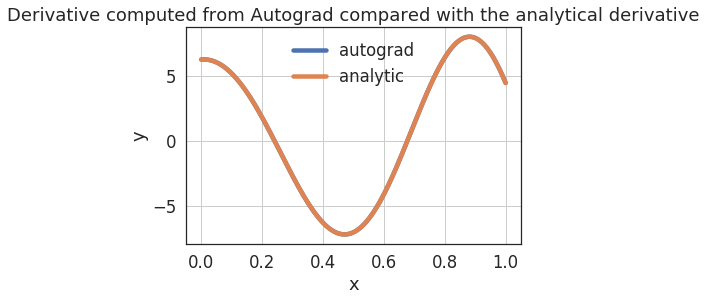

The max absolute difference is: 1.77636e-15


In [73]:
# From Optimization and and Gradient Methods, slide 44
# To do elementwise differentiation:
from autograd import elementwise_grad as egrad
import autograd.numpy as np

# To plot:
import matplotlib.pyplot as plt 


def f(x):
    return np.sin(2*np.pi*x + x**2)

def f_grad_analytic(x):
    return np.cos(2*np.pi*x + x**2)*(2*np.pi + 2*x)

# Do the comparison:
x = np.linspace(0,1,1000)

f_grad = egrad(f)

computed = f_grad(x)
analytic = f_grad_analytic(x)

plt.title('Derivative computed from Autograd compared with the analytical derivative')
plt.plot(x,computed,label='autograd')
plt.plot(x,analytic,label='analytic')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

print("The max absolute difference is: %g"%(np.max(np.abs(computed - analytic))))

In [0]:
class NeuralNetwork:  #Working version, no regression, one hidden layer
    def __init__(
            self,
            X_data,
            Y_data,
            trainingShare=0.5,
            n_hidden_neurons=50,
            n_categories=10,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0,
            fixed_LR=False):

        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.trainingShare = trainingShare
        self.split_data = self.SplitData(self.X_data_full, self.Y_data_full, self.trainingShare)
        self.XTrain = self.split_data[0].toarray()
        self.XTest = self.split_data[1].toarray()
        self.yTrain = self.split_data[2]
        self.yTest = self.split_data[3]

        self.n_inputs = self.XTrain.shape[0]
        self.n_features = self.XTrain.shape[1]
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.eta = eta
        self.lmbd = lmbd
        self.fixed_LR = fixed_LR

        self.create_biases_and_weights()
        self.accuracy_list = []
        self.cost_list = []

    def create_biases_and_weights(self):
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        self.hidden_bias = np.zeros((1, self.n_hidden_neurons)) + 0.01
        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        self.output_bias = np.zeros((1, self.n_categories)) + 0.01

    def feed_forward(self):
        # feed-forward for training
        self.z_h = np.matmul(self.XTrain_batch, self.hidden_weights) + self.hidden_bias
        self.a_h = self.SigmoidFunction(self.z_h)
        self.z_o = np.matmul(self.a_h, self.output_weights) + self.output_bias
        #exp_term = np.exp(self.z_o)
        #self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        self.probabilities = self.LogRegPredict(self.z_o)
        self.a_o = self.SigmoidFunction(self.z_o)

    def feed_forward_out(self, X):
        # feed-forward for output
        z_h = np.matmul(X, self.hidden_weights) + self.hidden_bias
        a_h = self.SigmoidFunction(z_h)
        z_o = np.matmul(a_h, self.output_weights) + self.output_bias
        a_o = self.SigmoidFunction(z_o)
        #exp_term = np.exp(z_o)
        #probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        probabilities = self.LogRegPredict(z_o)
        return probabilities

    def LogRegPredict(self, z_o):
      yPred = self.SigmoidFunction(z_o)
      for i in range(0, yPred.shape[0], 1):
        if yPred[i] <= 0.5:
          yPred[i] = 0
        else:
          yPred[i] = 1
      return yPred

    def backpropagation(self):
        #error_output = (self.probabilities - self.yTrain_batch) * self.a_o * (1 - self.a_o) #self.probabilities is binary 0-1 vector 
        error_output = (self.a_o - self.yTrain_batch) #* self.a_o * (1 - self.a_o) #self.a_o is 0 to 1 vector
        error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h * (1 - self.a_h)

        self.output_weights_gradient = np.matmul(self.a_h.T, error_output)
        self.output_bias_gradient = np.sum(error_output, axis=0)

        self.hidden_weights_gradient = np.matmul(self.XTrain_batch.T, error_hidden)
        self.hidden_bias_gradient = np.sum(error_hidden, axis=0)

        if self.lmbd > 0.0:
            self.output_weights_gradient += self.lmbd * self.output_weights
            self.hidden_weights_gradient += self.lmbd * self.hidden_weights

        self.output_weights -= self.eta * self.output_weights_gradient/self.batch_size
        self.output_bias -= self.eta * self.output_bias_gradient/self.batch_size
        self.hidden_weights -= self.eta * self.hidden_weights_gradient/self.batch_size
        self.hidden_bias -= self.eta * self.hidden_bias_gradient/self.batch_size
        
    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        #return np.argmax(probabilities, axis=1)
        return probabilities

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        t0, t1 = 5, 500
        self.accuracy_list.append(self.accuracy(self.yTest, self.predict(self.XTest)))
        for i in range(self.epochs):
            self.shuffled_data = self.shuffle(self.XTrain, self.yTrain) # Rows for XTrain, yTrain are shuffled for each epoch.
            self.XTrain_shuffled = self.shuffled_data[0]
            self.yTrain_shuffled = self.shuffled_data[1]
            for batch in range(int(self.XTrain.shape[0]/self.batch_size)):
                self.XTrain_batch = self.XTrain_shuffled[self.batch_size * batch: self.batch_size * (batch + 1), :] #Minibatch training data
                self.yTrain_batch = self.yTrain_shuffled[self.batch_size * batch: self.batch_size * (batch + 1)] #Minibatch training data
                
                if self.fixed_LR==False:
                  t = i*int(self.XTrain.shape[0]/self.batch_size) + batch #Variable learning rate
                  self.eta = self.step_length(t, t0, t1) #Variable learning rate
                #print(self.eta)
                
                self.feed_forward()
                self.backpropagation()
            self.accuracy_list.append(self.accuracy(self.yTest, self.predict(self.XTest)))
            
    def shuffle(self, XTrain, yTrain):
      random.seed(1)
      n_rows = list(range(0, XTrain.shape[0], 1))
      random.shuffle(n_rows)
      XTrain_post_shuffle = XTrain[n_rows,:]
      yTrain_post_shuffle = yTrain[n_rows]
      return XTrain_post_shuffle, yTrain_post_shuffle

    def step_length(self,t,t0,t1):
      return t0/(t+t1)

    def SplitData(self, X, y, trainingShare=0.5):
      seed  = 1
      XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size=trainingShare, \
                                              test_size = 1-trainingShare,
                                             random_state=seed)
      return XTrain, XTest, yTrain, yTest

    def accuracy(self, yTest, yPred):
      return  (yTest.flatten() == yPred.flatten()).sum()/len(yTest.flatten())
    
    def SigmoidFunction(self, x):
      sigma_fn = np.vectorize(lambda x: 1/(1+np.exp(-x)))
      return 1/(1+np.exp(-x))

[0.40888363452119575, 0.7073129538929235, 0.7345043067049485, 0.7537578111805439, 0.7682823847323087, 0.7794291504813377, 0.7868603276473569, 0.7919270393514609, 0.7946292855936498, 0.7956426279344705, 0.7973315318358385, 0.7990204357372066, 0.8003715588583009, 0.801216010808985, 0.8035804762709002, 0.805438270562405, 0.8061138321229522, 0.8072960648539098, 0.808816078365141, 0.8099983110960987, 0.8103360918763722, 0.8106738726566458, 0.8108427630467826, 0.8106738726566458, 0.8113494342171931, 0.8113494342171931, 0.8118561053876034, 0.8123627765580138, 0.813882790069245, 0.8145583516297923, 0.8150650228002027, 0.8157405843607499, 0.8159094747508867, 0.8164161459212971, 0.8165850363114339, 0.8164161459212971, 0.8165850363114339, 0.8167539267015707, 0.8170917074818442, 0.8175983786522547, 0.8181050498226651, 0.8181050498226651, 0.8182739402128019, 0.8184428306029387, 0.8177672690423915, 0.8177672690423915, 0.8177672690423915, 0.8174294882621179, 0.8172605978719811, 0.8174294882621179, 0.

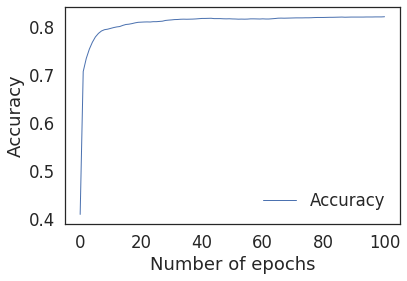

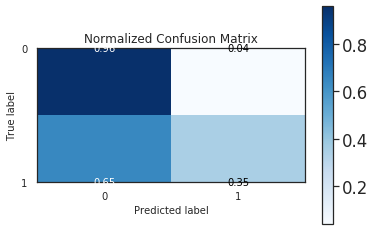

In [75]:
# Neural network
NN = NeuralNetwork(X_ccd, y, trainingShare=0.8, n_hidden_neurons=50, n_categories=1, epochs=100, batch_size=50, eta=1e-02, lmbd=0, fixed_LR=True)
NN.train()
test_predict = NN.predict(NN.XTest)
print(NN.accuracy_list)
print("Maximum accuracy :", max(NN.accuracy_list), "reached at epoch ", NN.accuracy_list.index(max(NN.accuracy_list)))

plt.figure()
plt.plot(list(range(0, len(NN.accuracy_list), 1)), NN.accuracy_list, '-', label = 'Accuracy', linewidth=1)
plt.ylabel("Accuracy")
plt.xlabel("Number of epochs")
plt.grid(False)
plt.legend(fontsize="medium") 
plt.legend()   
plt.show()
skplt.metrics.plot_confusion_matrix(NN.yTest.ravel(), test_predict, normalize=True)

0.7673130193905817
[0.7751503276805621, 0.7251537058306872, 0.7061685021282346, 0.7075873251807311, 0.7125194243632187, 0.7161002634957098, 0.7198837916357003, 0.7246807648131883, 0.7281940409431795, 0.7311668130531721, 0.7325180731031687, 0.7353557192081616, 0.7369096682656577, 0.7396797513681508, 0.7413012634281467, 0.7429903384906426, 0.7444767245456388, 0.7465711776231335, 0.7480575636781298, 0.748800756705628, 0.7510978987906223, 0.7519762178231201, 0.7532599148706168, 0.754003107898115, 0.7552868049456117, 0.7561651239781095, 0.7572461320181069, 0.7579217620431052, 0.7588676440781028, 0.7592730220931018, 0.7598810891156003, 0.7604891561380988, 0.7606918451455983, 0.7610972231605972, 0.7612323491655969, 0.7620431051955949, 0.7622457942030944, 0.7625836092155935, 0.7630565502330924, 0.7636646172555909, 0.7641375582730896, 0.7647456252955881, 0.7648807513005877, 0.7649483143030876, 0.7654888183230862, 0.7661644483480846, 0.7664347003580839, 0.7667049523680832, 0.7669076413755828, 0.

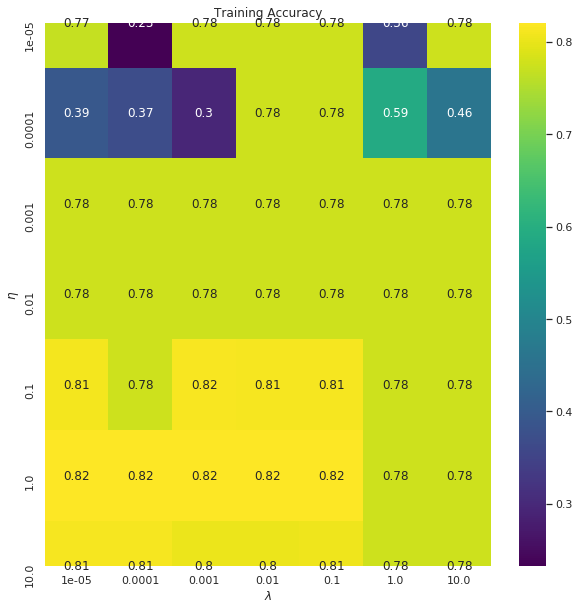

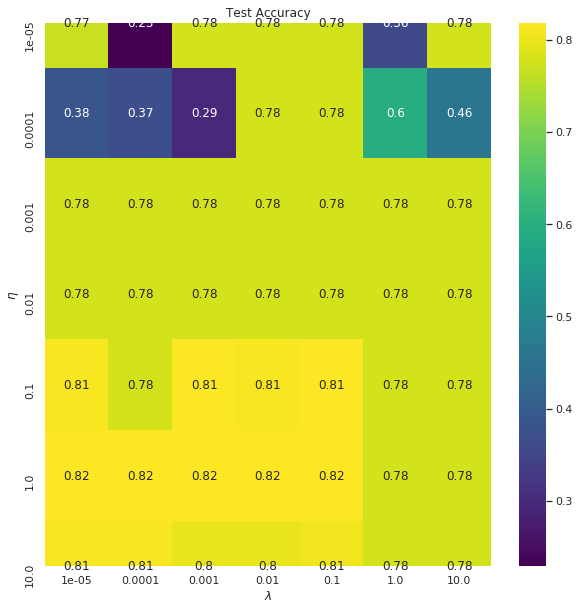

In [77]:
#Neural network
split_data = SplitData(X_ccd, y, trainingShare)
XTrain = split_data[0].toarray()
XTest = split_data[1].toarray()
yTrain = split_data[2]
yTest = split_data[3]

NN = NeuralNetwork(X_ccd, y, trainingShare=0.5, n_hidden_neurons=50, n_categories=1, epochs=50, batch_size=100, eta=0.01, lmbd=0.0)
NN.train()
test_predict = NN.predict(XTest)
print(accuracy(yTest, test_predict))
print(NN.accuracy_list)


eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)
# store the models for later use
DNN_numpy = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

# grid search
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = NeuralNetwork(X_ccd, y, eta=eta, lmbd=lmbd, epochs=50, batch_size=100,
                            n_hidden_neurons=1, n_categories=1, fixed_LR=True)
        dnn.train()
        
        DNN_numpy[i][j] = dnn
        
        test_predict = dnn.predict(XTest)
        
        print("Learning rate  = ", eta)
        print("Lambda = ", lmbd)
        print("Accuracy score on test set: ", accuracy_score(yTest, test_predict))
        print()

import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        dnn = DNN_numpy[i][j]
        
        train_pred = dnn.predict(dnn.XTrain) 
        test_pred = dnn.predict(dnn.XTest)

        train_accuracy[i][j] = accuracy_score(dnn.yTrain, train_pred)
        test_accuracy[i][j] = accuracy_score(dnn.yTest, test_pred)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis", xticklabels=lmbd_vals, yticklabels=eta_vals)
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis", xticklabels=lmbd_vals, yticklabels=eta_vals)
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

In [0]:
class NeuralNetworkML:  #Multiple hidden layers
    def __init__(
            self,
            X_data,
            Y_data,
            trainingShare=0.5,
            n_hidden_neurons_1=50,
            n_hidden_neurons_2=20,
            n_categories=10,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0,
            fixed_LR=False):

        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.trainingShare = trainingShare
        self.split_data = self.SplitData(self.X_data_full, self.Y_data_full, self.trainingShare)
        self.XTrain = self.split_data[0].toarray()
        self.XTest = self.split_data[1].toarray()
        self.yTrain = self.split_data[2]
        self.yTest = self.split_data[3]

        self.n_inputs = self.XTrain.shape[0]
        self.n_features = self.XTrain.shape[1]
        self.n_hidden_neurons_1 = n_hidden_neurons_1
        self.n_hidden_neurons_2 = n_hidden_neurons_2
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.eta = eta
        self.lmbd = lmbd
        self.fixed_LR = fixed_LR

        self.create_biases_and_weights()
        self.accuracy_list = []
        self.cost_list = []

    def create_biases_and_weights(self):
        self.hidden_weights_1 = np.random.randn(self.n_features, self.n_hidden_neurons_1)
        self.hidden_bias_1 = np.zeros((1, self.n_hidden_neurons_1)) + 0.01
        self.hidden_weights_2 = np.random.randn(self.n_hidden_neurons_1, self.n_hidden_neurons_2)
        self.hidden_bias_2 = np.zeros((1, self.n_hidden_neurons_2)) + 0.01
        self.output_weights = np.random.randn(self.n_hidden_neurons_2, self.n_categories)
        self.output_bias = np.zeros((1, self.n_categories)) + 0.01

    def feed_forward(self):
        # feed-forward for training
        self.z_h_1 = np.matmul(self.XTrain_batch, self.hidden_weights_1) + self.hidden_bias_1
        self.a_h_1 = self.SigmoidFunction(self.z_h_1)
        self.z_h_2 = np.matmul(self.a_h_1, self.hidden_weights_2) + self.hidden_bias_2
        self.a_h_2 = self.SigmoidFunction(self.z_h_2)
        self.z_o = np.matmul(self.a_h_2, self.output_weights) + self.output_bias
        #exp_term = np.exp(self.z_o)
        #self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        self.probabilities = self.LogRegPredict(self.z_o)
        self.a_o = self.SigmoidFunction(self.z_o)

    def feed_forward_out(self, X):
        # feed-forward for output
        z_h_1 = np.matmul(X, self.hidden_weights_1) + self.hidden_bias_1
        a_h_1 = self.SigmoidFunction(z_h_1)
        z_h_2 = np.matmul(a_h_1, self.hidden_weights_2) + self.hidden_bias_2
        a_h_2 = self.SigmoidFunction(z_h_2)
        z_o = np.matmul(a_h_2, self.output_weights) + self.output_bias
        a_o = self.SigmoidFunction(z_o)
        #exp_term = np.exp(z_o)
        #probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        probabilities = self.LogRegPredict(z_o)
        return probabilities

    def LogRegPredict(self, z_o):
      yPred = self.SigmoidFunction(z_o)
      for i in range(0, yPred.shape[0], 1):
        if yPred[i] <= 0.5:
          yPred[i] = 0
        else:
          yPred[i] = 1
      return yPred

    def backpropagation(self):
        error_output = (self.a_o - self.yTrain_batch) * self.a_o * (1 - self.a_o) #self.a_o is 0 to 1 vector, remove only for regression
        self.error_hidden_2 = np.matmul(error_output, self.output_weights.T) * self.a_h_2 * (1 - self.a_h_2)
        self.error_hidden_1 = np.matmul(self.error_hidden_2, self.hidden_weights_2.T) * self.a_h_1 * (1 - self.a_h_1)

        self.output_weights_gradient = np.matmul(self.a_h_2.T, error_output)
        self.output_bias_gradient = np.sum(error_output, axis=0)

        self.hidden_weights_gradient_2 = np.matmul(self.a_h_1.T, self.error_hidden_2)
        self.hidden_bias_gradient_2 = np.sum(self.error_hidden_2, axis=0)

        self.hidden_weights_gradient_1 = np.matmul(self.XTrain_batch.T, self.error_hidden_1)
        self.hidden_bias_gradient_1 = np.sum(self.error_hidden_1, axis=0)

        if self.lmbd > 0.0:
            self.output_weights_gradient += self.lmbd * self.output_weights
            self.hidden_weights_gradient_2 += self.lmbd * self.hidden_weights_2
            self.hidden_weights_gradient_1 += self.lmbd * self.hidden_weights_1
 
        self.output_weights -= self.eta * self.output_weights_gradient/self.batch_size
        self.output_bias -= self.eta * self.output_bias_gradient/self.batch_size

        self.hidden_weights_2 -= self.eta * self.hidden_weights_gradient_2/self.batch_size
        self.hidden_bias_2 -= self.eta * self.hidden_bias_gradient_2/self.batch_size
        self.hidden_weights_1 -= self.eta * self.hidden_weights_gradient_1/self.batch_size
        self.hidden_bias_1 -= self.eta * self.hidden_bias_gradient_1/self.batch_size
        
    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        #return np.argmax(probabilities, axis=1)
        return probabilities

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        t0, t1 = 5, 500
        self.accuracy_list.append(self.accuracy(self.yTest, self.predict(self.XTest)))
        for i in range(self.epochs):
            self.shuffled_data = self.shuffle(self.XTrain, self.yTrain) # Rows for XTrain, yTrain are shuffled for each epoch.
            self.XTrain_shuffled = self.shuffled_data[0]
            self.yTrain_shuffled = self.shuffled_data[1]
            for batch in range(int(self.XTrain.shape[0]/self.batch_size)):
                self.XTrain_batch = self.XTrain_shuffled[self.batch_size * batch: self.batch_size * (batch + 1), :] #Minibatch training data
                self.yTrain_batch = self.yTrain_shuffled[self.batch_size * batch: self.batch_size * (batch + 1)] #Minibatch training data
                
                if self.fixed_LR==False:
                  t = i*int(self.XTrain.shape[0]/self.batch_size) + batch #Variable learning rate
                  self.eta = self.step_length(t, t0, t1) #Variable learning rate
                #print(self.eta)
                
                self.feed_forward()
                self.backpropagation()
            self.accuracy_list.append(self.accuracy(self.yTest, self.predict(self.XTest)))
            
    def shuffle(self, XTrain, yTrain):
      random.seed(1)
      n_rows = list(range(0, XTrain.shape[0], 1))
      random.shuffle(n_rows)
      XTrain_post_shuffle = XTrain[n_rows,:]
      yTrain_post_shuffle = yTrain[n_rows]
      return XTrain_post_shuffle, yTrain_post_shuffle

    def step_length(self,t,t0,t1):
      return t0/(t+t1)

    def SplitData(self, X, y, trainingShare=0.5):
      seed  = 1
      XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size=trainingShare, \
                                              test_size = 1-trainingShare,
                                             random_state=seed)
      return XTrain, XTest, yTrain, yTest

    def accuracy(self, yTest, yPred):
      return  (yTest.flatten() == yPred.flatten()).sum()/len(yTest.flatten())
    
    def SigmoidFunction(self, x):
      sigma_fn = np.vectorize(lambda x: 1/(1+np.exp(-x)))
      return 1/(1+np.exp(-x))

In [0]:
# Neural network with multiple layers
NN = NeuralNetworkML(X_ccd, y, trainingShare=0.8, n_hidden_neurons_1=24, n_hidden_neurons_2=12, n_categories=1, epochs=100, batch_size=100, eta=1e-1, lmbd=0, fixed_LR=True)
NN.train()
test_predict = NN.predict(NN.XTest)
print(NN.accuracy_list)
print("Maximum accuracy :", max(NN.accuracy_list), "reached at epoch ", NN.accuracy_list.index(max(NN.accuracy_list)))

plt.figure()
plt.plot(list(range(0, len(NN.accuracy_list), 1)), NN.accuracy_list, '-', label = 'Accuracy', linewidth=1)
plt.ylabel("Accuracy")
plt.xlabel("Number of epochs")
plt.grid(False)
plt.legend(fontsize="medium") 
plt.legend()   
plt.show()

skplt.metrics.plot_confusion_matrix(NN.yTest.ravel(), test_predict, normalize=True)

In [0]:
class NeuralNetworkML:  #Multiple hidden layers
    def __init__(
            self,
            X_data,
            Y_data,
            trainingShare=0.5,
            n_hidden_layers=2,
            n_hidden_neurons=[24,12],
            n_categories=10,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0,
            fixed_LR=False,
            method="classification",
            activation="sigmoid"):

        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.trainingShare = trainingShare
        self.method = method
        self.split_data = self.SplitData(self.X_data_full, self.Y_data_full, self.trainingShare)
        if self.method=="classification":
          self.XTrain = self.split_data[0].toarray()
          self.XTest = self.split_data[1].toarray()
        else:
          self.XTrain = self.split_data[0]
          self.XTest = self.split_data[1]
        self.yTrain = self.split_data[2]
        self.yTest = self.split_data[3]

        self.n_inputs = self.XTrain.shape[0]
        self.n_features = self.XTrain.shape[1]
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.eta = eta
        self.lmbd = lmbd
        self.fixed_LR = fixed_LR
        self.activation = activation

        self.create_biases_and_weights()
        self.accuracy_list = []
        self.cost_list = []
        self.models = []

    def create_biases_and_weights(self):
        for n in range(self.n_hidden_layers):
          exec("self.n_hidden_neurons_" + str(eval("n + 1")) + "=" + str(eval("self.n_hidden_neurons[n]")))
        for n in range(self.n_hidden_layers):
          if n==0:
            exec("self.hidden_weights_1 = np.random.randn(self.n_features, self.n_hidden_neurons_1)")
            exec("self.hidden_bias_1 = np.zeros((1, self.n_hidden_neurons_1)) + 0.01")
          else:
            exec("self.hidden_weights_" + str(eval("n + 1")) + "= np.random.randn(self.n_hidden_neurons_" + str(eval("n")) + ", self.n_hidden_neurons_" + str(eval("n+1")) + ")")
            exec("self.hidden_bias_" + str(eval("n + 1")) + "= np.zeros((1, self.n_hidden_neurons_" + str(eval("n + 1")) + ")) + 0.01")
          exec("self.output_weights = np.random.randn(self.n_hidden_neurons_" + str(eval("self.n_hidden_layers")) + ", self.n_categories)")
          exec("self.output_bias = np.zeros((1, self.n_categories)) + 0.01")

    def act(self, x):
      if self.activation=="sigmoid":
        return self.SigmoidFunction(x)
      elif self.activation=="ELU":
        return self.ELU(x, alpha=0.01)
      elif self.activation=="LeakyReLU":
        return self.LeakyReLU(x, alpha=0.01)

    def feed_forward(self):
        for n in range(self.n_hidden_layers):
          if n==0:
            self.z_h_1 = np.matmul(self.XTrain_batch, self.hidden_weights_1) + self.hidden_bias_1
            self.a_h_1 = self.act(self.z_h_1)
          else:
            exec("self.z_h_" + str(eval("n + 1")) + " = np.matmul(self.a_h_" + str(eval("n")) + ", self.hidden_weights_" + str(eval("n + 1")) + ") + self.hidden_bias_" + str(eval("n + 1")))
            exec("self.a_h_" + str(eval("n + 1")) + " = self.act(self.z_h_" + str(eval("n + 1")) + ")")
        exec("self.z_o = np.matmul(self.a_h_" + str(eval("self.n_hidden_layers")) + ", self.output_weights) + self.output_bias")
        self.probabilities = self.LogRegPredict(self.z_o)
        self.a_o = self.act(self.z_o)
      
    def feed_forward_out(self, X):
        for n in range(self.n_hidden_layers):
          if n==0:
            z_h_1 = np.matmul(X, self.hidden_weights_1) + self.hidden_bias_1
            a_h_1 = self.act(z_h_1)
          # feed-forward for output
          else:
            exec("z_h_" + str(eval("n + 1")) + " = np.matmul(a_h_" + str(eval("n")) + ", self.hidden_weights_" + str(eval("n + 1")) + ") + self.hidden_bias_" + str(eval("n + 1")))
            exec("a_h_" + str(eval("n + 1")) + " = self.act(z_h_" + str(eval("n + 1")) + ")")
        z_o=eval("np.matmul(a_h_" + str(eval("self.n_hidden_layers")) + ", self.output_weights) + self.output_bias")
        a_o = self.act(z_o)
        if self.method=="classification":
          probabilities = self.LogRegPredict(z_o)
        elif self.method=="regression":
          yPred = z_o
          probabilities = z_o
        return probabilities
          
    def LogRegPredict(self, z_o):
      yPred = self.SigmoidFunction(z_o)
      for i in range(0, yPred.shape[0], 1):
        if yPred[i] <= 0.5:
          yPred[i] = 0
        else:
          yPred[i] = 1
      return yPred

    def backpropagation(self):
      for n in range(self.n_hidden_layers - 1, -1, -1):
        if n + 1 == self.n_hidden_layers:
          if self.method=="regression":
            error_output = (self.a_o - self.yTrain_batch) #Cost function: derivative of mean squared error
          else:
            error_output = (self.a_o - self.yTrain_batch) * self.a_o * (1 - self.a_o) #Cost function: derivative of cross-entropy
          if self.n_hidden_layers==1:
            self.error_hidden_1 = np.matmul(error_output, self.output_weights.T) * self.a_h_1 * (1 - self.a_h_1)
            self.output_weights_gradient = np.matmul(self.a_h_1.T, error_output)
            self.output_bias_gradient = np.sum(error_output, axis=0)
            self.hidden_weights_gradient_1 = np.matmul(self.XTrain_batch.T, self.error_hidden_1)
            self.hidden_bias_gradient_1 = np.sum(self.error_hidden_1, axis=0)
          else:
            exec("self.error_hidden_" + str(eval("self.n_hidden_layers")) + " = np.matmul(error_output, self.output_weights.T) * self.a_h_" + str(eval("self.n_hidden_layers")) + " * (1 - self.a_h_" + str(eval("self.n_hidden_layers")) + ")")
            exec("self.hidden_weights_gradient_" + str(eval("n + 1")) + " = np.matmul(self.a_h_" + str(eval("n")) + ".T, self.error_hidden_" + str(eval("n + 1")) + ")")
            exec("self.hidden_bias_gradient_" + str(eval("n + 1")) + " = np.sum(self.error_hidden_" + str(eval("n + 1")) + ", axis=0)")
            exec("self.output_weights_gradient = np.matmul(self.a_h_" + str(eval("n + 1")) + ".T, error_output)")
          self.output_bias_gradient = np.sum(error_output, axis=0)
        elif n > 0:
          exec("self.error_hidden_" + str(eval("n+1")) + " = np.matmul(self.error_hidden_" + str(eval("n + 2")) + ", self.hidden_weights_" + str(eval("n + 2")) + ".T) * self.a_h_" + str(eval("n+1")) + " * (1 - self.a_h_" + str(eval("n+1")) + ")")
          exec("self.hidden_weights_gradient_" + str(eval("n + 1")) + " = np.matmul(self.a_h_" + str(eval("n")) + ".T, self.error_hidden_" + str(eval("n + 1")) + ")")
          exec("self.hidden_bias_gradient_" + str(eval("n + 1")) + " = np.sum(self.error_hidden_" + str(eval("n + 1")) + ", axis=0)")
        else:
          if self.n_hidden_layers == 1:
            self.error_hidden_1 = np.matmul(error_output, self.output_weights.T) * self.a_h_1 * (1 - self.a_h_1)
          else:
            self.error_hidden_1 = np.matmul(self.error_hidden_2, self.hidden_weights_2.T) * self.a_h_1 * (1 - self.a_h_1)
            self.hidden_weights_gradient_1 = np.matmul(self.XTrain_batch.T, self.error_hidden_1)
            self.hidden_bias_gradient_1 = np.sum(self.error_hidden_1, axis=0)

      if self.lmbd > 0.0:
        self.output_weights_gradient += self.lmbd * self.output_weights
        for n in range(self.n_hidden_layers - 1, -1, -1):
          exec("self.hidden_weights_gradient_" + str(eval("n + 1")) + " += self.lmbd * self.hidden_weights_" + str(eval("n + 1")))
 
      self.output_weights -= self.eta * self.output_weights_gradient/self.batch_size
      self.output_bias -= self.eta * self.output_bias_gradient/self.batch_size

      for n in range(self.n_hidden_layers - 1, -1, -1):
        exec("self.hidden_weights_" + str(eval("n + 1")) + " -= self.eta * self.hidden_weights_gradient_" + str(eval("n + 1")) + "/self.batch_size")
        exec("self.hidden_bias_" + str(eval("n + 1")) + " -= self.eta * self.hidden_bias_gradient_" + str(eval("n + 1")) + "/self.batch_size")

    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        #return np.argmax(probabilities, axis=1)
        return probabilities

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        t0, t1 = 5, 500
        self.accuracy_list.append(self.accuracy(self.yTest, self.predict(self.XTest)))
        for i in range(self.epochs):
            self.shuffled_data = self.shuffle(self.XTrain, self.yTrain) # Rows for XTrain, yTrain are shuffled for each epoch.
            self.XTrain_shuffled = self.shuffled_data[0]
            self.yTrain_shuffled = self.shuffled_data[1]
            for batch in range(int(self.XTrain.shape[0]/self.batch_size)):
                self.XTrain_batch = self.XTrain_shuffled[self.batch_size * batch: self.batch_size * (batch + 1), :] #Minibatch training data
                self.yTrain_batch = self.yTrain_shuffled[self.batch_size * batch: self.batch_size * (batch + 1)] #Minibatch training data
                
                if self.fixed_LR==False:
                  t = i*int(self.XTrain.shape[0]/self.batch_size) + batch #Variable learning rate
                  self.eta = self.step_length(t, t0, t1) #Variable learning rate
                #print(self.eta)
                
                self.feed_forward()
                self.backpropagation()
            self.accuracy_list.append(self.accuracy(self.yTest, self.predict(self.XTest)))
            
    def shuffle(self, XTrain, yTrain):
      random.seed(1)
      n_rows = list(range(0, XTrain.shape[0], 1))
      random.shuffle(n_rows)
      XTrain_post_shuffle = XTrain[n_rows,:]
      yTrain_post_shuffle = yTrain[n_rows]
      return XTrain_post_shuffle, yTrain_post_shuffle

    def step_length(self,t,t0,t1):
      return t0/(t+t1)

    def SplitData(self, X, y, trainingShare=0.5):
      seed  = 1
      XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size=trainingShare, \
                                              test_size = 1-trainingShare,
                                             random_state=seed)
      return XTrain, XTest, yTrain, yTest

    def accuracy(self, yTest, yPred):
      if self.method=="classification":
        return  (yTest.flatten() == yPred.flatten()).sum()/len(yTest.flatten())
      if self.method=="regression":
        self.models.append(self.predict(self.X_data_full))
        return np.mean((self.yTest - self.predict(self.XTest))**2)
    
    def SigmoidFunction(self, x):
      sigma_fn = np.vectorize(lambda x: 1/(1+np.exp(-x)))
      return 1/(1+np.exp(-x))

    def LogRegPredict(self, z_o):
      yPred = self.SigmoidFunction(z_o)
      for i in range(0, yPred.shape[0], 1):
        if yPred[i] <= 0.5:
          yPred[i] = 0
        else:
          yPred[i] = 1
      return yPred

    def ELU(self, x, alpha=0.01):
      ao = x
      for i in range(0, x.shape[0], 1):
        for j in range(0, x.shape[1], 1):
          if x[i,j] < 0:
            ao[i,j] = alpha*(np.exp(x[i,j]) - 1)
      return ao

    def LeakyReLU(self, x, alpha=0.01):
      ao = x
      for i in range(0, x.shape[0], 1):
        for j in range(0, x.shape[1], 1):
          if x[i,j] <= 0:
            ao[i,j] = alpha*x[i,j]
      return ao




[0.7787535889207904, 0.7897314642796824, 0.7990204357372066, 0.8040871474413106, 0.807127174463773, 0.8103360918763722, 0.8115183246073299, 0.8125316669481506, 0.8137138996791082, 0.8152339131903394, 0.8162472555311603, 0.8179361594325283, 0.8187806113832123, 0.8179361594325283, 0.8199628441141699, 0.8211450768451275, 0.8230028711366323, 0.8230028711366323, 0.823340651916906, 0.8231717615267691, 0.8236784326971796, 0.8240162134774531, 0.8248606654281372, 0.825029555818274, 0.825029555818274, 0.8251984462084108, 0.8248606654281372, 0.825029555818274, 0.8251984462084108, 0.8251984462084108, 0.8253673365985476, 0.8255362269886843, 0.8253673365985476, 0.8257051173788211, 0.8258740077689579, 0.8258740077689579, 0.8258740077689579, 0.8257051173788211, 0.8255362269886843, 0.8251984462084108, 0.8258740077689579, 0.8258740077689579, 0.8255362269886843, 0.8253673365985476, 0.8251984462084108, 0.825029555818274, 0.8251984462084108, 0.8251984462084108, 0.8251984462084108, 0.8253673365985476, 0.825

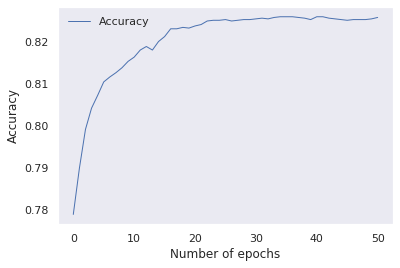

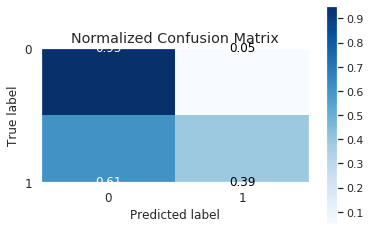

In [85]:
# Neural network with multiple layers - classification

NN = NeuralNetworkML(X_ccd, y, trainingShare=0.8, n_hidden_layers=2, n_hidden_neurons=[24,12], n_categories=1, 
                     epochs=50, batch_size=100, eta=1, lmbd=1e-05, fixed_LR=True, activation="sigmoid")
NN.train()
test_predict = NN.predict(NN.XTest)
print(NN.accuracy_list)
print("Maximum accuracy :", max(NN.accuracy_list), "reached at epoch ", NN.accuracy_list.index(max(NN.accuracy_list)))

plt.figure()
plt.plot(list(range(0, len(NN.accuracy_list), 1)), NN.accuracy_list, '-', label = 'Accuracy', linewidth=1)
plt.ylabel("Accuracy")
plt.xlabel("Number of epochs")
plt.grid(False)
plt.legend(fontsize="medium") 
plt.legend()   
plt.show()

skplt.metrics.plot_confusion_matrix(NN.yTest.ravel(), test_predict, normalize=True)

In [0]:
"""Make data for Franke function"""
np.random.seed(1)

def FrankeFunction(x,y):
  term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
  term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
  term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
  term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
  return term1 + term2 + term3 + term4

def f_noise_franke(x, y):
  shape_z = np.shape(FrankeFunction(x,y))
  noise_z = 0.1*np.random.randn(shape_z[0], shape_z[1])
  return noise_z

def FrankeFunctionData():
  x = np.arange(0, 1, 0.005)
  y = np.arange(0, 1, 0.005)
  x, y = np.meshgrid(x,y)
  z = FrankeFunction(x, y) + f_noise_franke(x, y)
  
  # Plot the surface.
  fig = plt.figure()
  ax = fig.gca(projection="3d")
  surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,linewidth=0, 
                        antialiased=False)
  # Customize the z axis.
  ax.set_zlim(-0.10, 1.40)
  ax.zaxis.set_major_locator(LinearLocator(10))
  ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
  ax.tick_params(labelsize=8)
  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)
  plt.show()
  
  # Unravel xy meshgrid and z matrix into vectors
  x = np.ravel(x)
  y = np.ravel(y)
  z = np.ravel(z)

  # Create design matrix of polynomial degree 5
  X = np.c_[x, y, 
            x*x, y*y, x*y,
            x*x*x, x*x*y, x*y*y, y*y*y,
            x*x*x*x, x*x*x*y, x*x*y*y, x*y*y*y, y*y*y*y,
            x*x*x*x*x, x*x*x*x*y, x*x*x*y*y, x*x*y*y*y, x*y*y*y*y, y*y*y*y*y]
  DesignMatrix = pd.DataFrame(X)
  DesignMatrix.columns = [
            #'1',
            "x", "y", 
            "x^2", "xy", "y^2",
            "x^3", "x^2y", "xy^2", "y^3",
            "x^4", "x^3y", "x^2y^2", "xy^3", "y^4",
            "x^5", "x^4y", "x^3y^2", "x^2y^3", "xy^4", "y^5"]
  Franke_X = X.copy()
  Franke_z = z.copy()[:, np.newaxis]
  #print(Franke_X.shape)
  #print(Franke_z.shape)
  return X, x, y, z

type(X_ccd), type(y) <class 'scipy.sparse.csr.csr_matrix'> <class 'numpy.ndarray'>


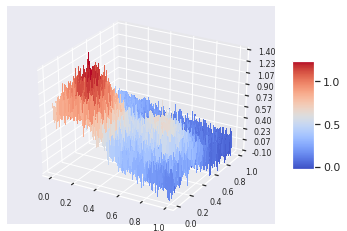

[5.325523653028629, 1.2332869832097435, 1.32114145998963, 1.4046857705493645, 1.454211860430523, 1.4861662009112526, 1.5099804781199964, 1.5299293900895943, 1.5477576613822142, 1.5641128183435975, 1.579210842864506, 1.5931240910084636, 1.6058980012579926, 1.6175924193595124, 1.6282904449996645, 1.638094189635979, 1.6471164057525243, 1.6554720996100378, 1.663271830050518, 1.6706171535244316, 1.6775980603667777, 1.6842919924017805, 1.6907639795939007, 1.6970674829237413, 1.7032456193549117, 1.7093325374549013, 1.7153547922141028, 1.7213326293626239, 1.7272811334344949, 1.7332112229398415, 1.739130493875779, 1.7450439227452335, 1.7509544449255323, 1.7568634256175377, 1.7627710400960266, 1.7686765784898113, 1.7745786884226797, 1.7804755668819805, 1.7863651108358363, 1.7922450344781273, 1.798112959568895, 1.8039664841532135, 1.8098032339609575, 1.815620899986417, 1.8214172650923082, 1.8271902219501148, 1.832937784196322, 1.8386580923319524, 1.8443494156048714, 1.850010150879717, 1.855638819

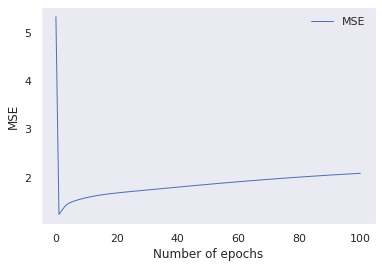

In [87]:
# Neural network with multiple layers - regression
print("type(X_ccd), type(y)", type(X_ccd), type(y))
# Creating Franke function
ffd = FrankeFunctionData()
X_ffd = ffd[0]
y_ffd = ffd[3][:, np.newaxis]

NN = NeuralNetworkML(X_ffd, y_ffd, trainingShare=0.8, n_hidden_layers=3, n_hidden_neurons=[200, 100, 50], n_categories=1,
                     epochs=100, batch_size=100, eta=1e-3, lmbd=0, fixed_LR=True, method="regression", activation="sigmoid")
NN.train()
test_predict = NN.predict(NN.XTest)
best_prediction = NN.models[NN.accuracy_list.index(min(NN.accuracy_list))]
print(NN.accuracy_list)
print("Minimum MSE :", min(NN.accuracy_list), "reached at epoch ", NN.accuracy_list.index(min(NN.accuracy_list)))

plt.figure()
plt.plot(list(range(0, len(NN.accuracy_list), 1)), NN.accuracy_list, '-', label = 'MSE', linewidth=1)
plt.ylabel("MSE")
plt.xlabel("Number of epochs")
plt.grid(False)
plt.legend(fontsize="medium") 
plt.legend()   
plt.show()

#skplt.metrics.plot_confusion_matrix(NN.yTest.ravel(), test_predict, normalize=True)

          0         1         2    ...       197       198       199
0   -0.086796 -0.078507 -0.070165  ... -1.818234 -1.808641 -1.798551
1   -0.070320 -0.061941 -0.053516  ... -1.778499 -1.768605 -1.758275
2   -0.054115 -0.045636 -0.037119  ... -1.738561 -1.728383 -1.717828
3   -0.038221 -0.029634 -0.021016  ... -1.698494 -1.688045 -1.677284
4   -0.022678 -0.013975 -0.005246  ... -1.658367 -1.647667 -1.636715
..        ...       ...       ...  ...       ...       ...       ...
195 -1.989654 -1.989266 -1.988832  ... -1.284062 -1.330602 -1.377523
196 -2.018764 -2.018733 -2.018655  ... -1.256010 -1.301636 -1.347800
197 -2.047172 -2.047515 -2.047813  ... -1.227818 -1.272401 -1.317690
198 -2.074894 -2.075632 -2.076324  ... -1.199585 -1.242993 -1.287289
199 -2.101952 -2.103106 -2.104214  ... -1.171406 -1.213502 -1.256687

[200 rows x 200 columns]


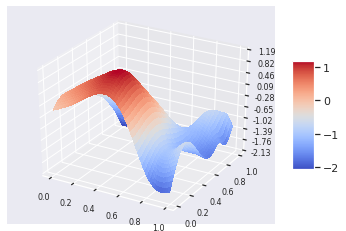

In [88]:
#Neural network using scikit-learn
best_prediction = NN.models[NN.accuracy_list.index(min(NN.accuracy_list))]
ff_pred = best_prediction.copy()
ff_pred = np.reshape(ff_pred, (200, 200))
print(pd.DataFrame(ff_pred))
x = np.arange(0, 1, 0.005)
y = np.arange(0, 1, 0.005)
x, y = np.meshgrid(x,y)
# Plot the predicted Franke function
fig = plt.figure()
ax = fig.gca(projection="3d")
surf = ax.plot_surface(x, y, ff_pred, cmap=cm.coolwarm,linewidth=0, 
                      antialiased=False)
# Customize the z axis.
#ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.tick_params(labelsize=8)
plt.show()
